# **Setting**

In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import os
import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.spatial import distance
import matplotlib.pyplot as plt
import warnings


from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 999


In [2]:
#파라미터 설정
data_path = 'storage/shop_data/interaction_data.csv'
_num_recommendations=10
_viewer_threshold=5
item_id_var = 'ITEM_ID'
user_id_var = 'USER_ID'
event = 'EVENT_TYPE'
timestamp = 'TIMESTAMP'

In [3]:
data_path = 'storage/movie_data/interaction_data.csv'
_num_recommendations=10
_viewer_threshold=5
item_id_var = 'ITEM_ID'
user_id_var = 'USER_ID'
event = 'EVENT_TYPE'
timestamp = 'TIMESTAMP'

In [4]:
#데이터 살펴보기
data= pd.read_csv(data_path)
data.head(3)
data[item_id_var] = data[item_id_var].astype(str)
data[user_id_var] = data[user_id_var].astype(str)

In [5]:
#interaction 데이터셋 생성
interaction_df=data[[item_id_var, user_id_var, event, timestamp]]
if data[event].dtypes != float:
    interaction_df.loc[:, event] = 1

#user 데이터셋 생성
user_df = data[[user_id_var]].drop_duplicates(user_id_var).reset_index(drop=True)

#item 데이터셋 생성
item_df = data[[item_id_var]].drop_duplicates(item_id_var).reset_index(drop=True)

# **Matrix Factorization**

In [24]:
def calculate_similarity(interaction_df, latent_features=50):
    pt = pd.pivot_table(index=user_id_var, columns=item_id_var, values=event, data=interaction_df, fill_value=0) #interaction데이터 pivot table 생성
    pt_m = pt.to_numpy()                                     # pivot table 생성
    user_ratings_mean = np.mean(pt_m, axis = 1)              # 사용자별 rating 평균 구하기
    df_demeaned = pt_m - user_ratings_mean.reshape(-1, 1)    # pivot table에서 rating 평균 빼기
    U, sigma, Vt = svds(df_demeaned, latent_features)        # SVD 분해  
    sigma = np.diag(sigma)                        
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, index=pt.index, columns = pt.columns)
    return preds_df

preds_df = calculate_similarity(interaction_df)

In [25]:
#아이템별 precision@k와 recall@k의 값을 알려줌
def precision_recall(preds_df, item_df, interaction_df, num, user_id):

    def intersect(a, b):
        return list(set(a) & set(b))
    
    
    #유저 아이디 df
    user_id_df = interaction_df[interaction_df[user_id_var]==user_id]
    
    #유저 아이디가 본 아이텤 df
    user_item_df = item_df[item_df[item_id_var].isin(user_id_df[item_id_var].tolist())]
    user_item_list = user_item_df[item_id_var].tolist()
    
    #추천 아이템 추출
    sorted_user_predictions = pd.DataFrame(preds_df.loc[user_id, :].sort_values(ascending=False).reset_index())
    sorted_user_predictions.columns = [item_id_var, 'Predictions']
    
    recommend_total_list_df = sorted_user_predictions.head(10)
    recommend_total_list = recommend_total_list_df[item_id_var].tolist()
    
    #순수 추천 아이템 리스트

    recommend_df = item_df[~item_df[item_id_var].isin(user_item_df[item_id_var])].merge(sorted_user_predictions, how='inner',on=item_id_var).sort_values('Predictions', ascending=False).head(10)
    
    
    #지표 산정
    precision = len(intersect(user_item_list, recommend_total_list))/ len(recommend_total_list)
    recall = len(intersect(user_item_list, recommend_total_list)) / len(user_item_list)
    
    return precision, recall, user_item_df, recommend_df


def perf_metric(preds_df, item_df, interaction_df, num):
    
    user_item_dfs = pd.DataFrame()
    recommend_dfs = pd.DataFrame()
    dict_list = []
    for USER_ID in tqdm.tqdm(interaction_df[user_id_var].unique()):
    #for USER_ID in tqdm.tqdm(['2']):
        precision, recall, user_item_df, recommend_df = precision_recall(preds_df, item_df, interaction_df, num, USER_ID)
        dict_ = {}
        dict_.update({"userID" : USER_ID})
        dict_.update({f"precision@{num}" : precision})
        dict_.update({f"recall@{num}" : recall})
        dict_list.append(dict_)
        
        #이미 user가 선정했던 item 확인
        user_item_df.loc[:, user_id_var] = USER_ID
        user_item_dfs= pd.concat([user_item_dfs, user_item_df], axis=0)
    
    
        #상위 추천 item 중 이미 user가 선정했던 item 제외 후 추천 목록 추출
        recommend_df.loc[:, user_id_var] = USER_ID
        recommend_dfs = pd.concat([recommend_dfs, recommend_df], axis=0)
    accuracy_df = pd.DataFrame(dict_list)
    return accuracy_df, user_item_dfs, recommend_dfs

accuracy_df, user_item_dfs, recommend_dfs = perf_metric(preds_df, item_df, interaction_df, 10)

100%|██████████████████████████████████████████████████████████████████████████████| 5250/5250 [03:06<00:00, 28.15it/s]


In [ ]:
item_df[~item_df[item_id_var].isin(user_item_list)]

In [26]:
user_item_dfs

,ITEM_ID,USER_ID
0,26bb732f-9159-432f-91ef-bad14fedd298,3156
127,94cc3c8d-7efd-4f7b-84d0-9996f7e90c2f,3156
250,8c84a139-aabd-47d6-a5aa-87510a8d5ae9,3156
479,e65ad5b5-6860-4444-b873-9368c49cf30c,3156
590,c0779eb2-bcb7-406a-9d60-cbb511ebed92,3156
...,...,...
1911,55b3f4ff-7a92-4ad7-bc1b-59c98c23c6d9,4059
2024,8759b4e2-51cc-456f-a224-01a34d04db2b,4059
2108,4e44c0c1-40d0-43dd-a7fb-8454d779296d,4059
2202,1d045c07-ef58-445c-8f73-93b466e6ccf2,4059


In [27]:
recommend_dfs

,ITEM_ID,Predictions,USER_ID
913,56e24d72-d09a-4ec5-8da9-d840c9f4795f,0.221899,3156
1808,e9771bb4-cac0-45b4-9e7f-9928ea597e4d,0.147352,3156
421,ba0c2cb6-26b8-488f-81ad-0fa52eb04940,0.122130,3156
1771,c9eed2f3-8275-47a6-b485-166162262c70,0.112900,3156
1857,092a278e-4d04-4ce3-bc18-e8a0491a9fb5,0.103606,3156
...,...,...,...
381,b2f9ea63-f7d4-4944-84ce-208164326c8e,0.167687,4059
1484,5449ebf6-1579-4fdc-8e02-7f631d2cdfbd,0.162414,4059
845,afdd9c41-2762-45bf-b6a7-e3fb8f1b34ba,0.146433,4059
1996,1bcb66c4-ee9d-4c0c-ba53-168cb243569f,0.133139,4059


In [28]:
print('TASK : 사용자별 상품 추천')
print('분석 알고리즘 : 상품-사용자 연계 추천')
print(f'사용자 변수: {user_id_var} ({interaction_df[user_id_var].nunique()})')
print(f'사용자 변수: {item_id_var} ({interaction_df[item_id_var].nunique()})')
print(f'모델 훈련 개수 : {len(interaction_df)}개')
print(f'모델 검증 개수 : {int(len(interaction_df)*0.1)}개') #본사업에서 따로 구현 X
print('검증 기준 : 모든 사용자의 최근 사용(Timestamp) 내역')
print('성능 지표 : Precision@K, Recall@K')
print(f"Precision@K : {np.round(np.mean(accuracy_df['precision@10']),3)}")
print(f"Recall@K    : {np.round(np.mean(accuracy_df['recall@10']),3)}")

TASK : 사용자별 상품 추천
분석 알고리즘 : 상품-사용자 연계 추천
사용자 변수: USER_ID (5250)
사용자 변수: ITEM_ID (2449)
모델 훈련 개수 : 587719개
모델 검증 개수 : 58771개
검증 기준 : 모든 사용자의 최근 사용(Timestamp) 내역
성능 지표 : Precision@K, Recall@K
Precision@K : 0.327
Recall@K    : 0.254


# USER-BASED

In [51]:
matrix = interaction_df.pivot_table(index = user_id_var, columns = item_id_var, values=event)
matrix_norm =matrix.subtract(matrix.mean(axis=1), axis = 'rows')
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity= pd.DataFrame(user_similarity_cosine, index = matrix_norm.index, columns = matrix_norm.index)

In [52]:
def make_user_based_df(user_similarity, matrix_norm, userid, num):
    user_similarity_drop = user_similarity.drop(index=userid) #userid 제외
    similar_users = user_similarity_drop[userid].sort_values(ascending=False)[:n] #user_similarity를 통해 자신과 비슷한 user 추출
    picked_userid = matrix_norm[matrix_norm.index == userid].dropna(axis=1, how='all') #자신이 선택했던 item 추출
    similar_user_items = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all') #비슷한 유저가 선택한 아이템 추출
    item_score = {}
    for i in similar_user_items.columns : 
        items_rating = similar_user_items[i]
        total, count = 0, 0
        for u in similar_users.index:
            if pd.isna(items_rating[u]) == False:
                score = similar_users[u] * items_rating[u]
                total += score
                count += 1
        item_score[i] = total / count
    item_score = pd.DataFrame(item_score.items(), columns = [item_id_var,'Predictions'])
    item_score_df = item_score.sort_values(by = 'Predictions', ascending=False).head(num)
    return item_score_df

In [53]:
def perf_metric(interaction_df, user_similarity, matrix_norm, num):
    recommend_dfs = pd.DataFrame()
    for USER_ID in tqdm.tqdm(interaction_df[user_id_var].unique()):
        recommend_df = make_user_based_df(user_similarity, matrix_norm, USER_ID, num)
      
        #상위 추천 item 중 이미 user가 선정했던 item 제외 후 추천 목록 추출
        recommend_df.loc[:, user_id_var] = USER_ID
        recommend_dfs = pd.concat([recommend_dfs, recommend_df], axis=0)
    return recommend_dfs

In [54]:
recommend_dfs = perf_metric(interaction_df, user_similarity, matrix_norm, 10)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:08:33<00:00,  2.43it/s]


In [55]:
recommend_dfs

,ITEM_ID,Predictions,USER_ID
197,66934,0.592957,1
167,527,0.379100,1
76,2686,0.359368,1
30,1449,0.359368,1
8,110,0.349039,1
...,...,...,...
348,1260,0.344325,10000
2870,98056,0.344325,10000
2336,6985,0.344325,10000
2642,8620,0.344325,10000


In [6]:
matrix = interaction_df.pivot_table(index = user_id_var, columns = item_id_var, values=event)
matrix_norm =matrix.subtract(matrix.mean(axis=1), axis = 'rows')

In [10]:
matrix_norm

ITEM_ID         1        10  100  1000  100010  100013  100017  100034  \
USER_ID                                                                  
1       NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       
10       0.809917 NaN       NaN  NaN   NaN     NaN     NaN     NaN       
100      0.065558 NaN       NaN  NaN   NaN     NaN     NaN     NaN       
1000     0.685417 NaN       NaN  NaN   NaN     NaN     NaN     NaN       
10000   NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       
...           ...  ..        ..   ..    ..      ..      ..      ..       
9995    NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       
9996     0.424324  0.424324 NaN  NaN   NaN     NaN     NaN     NaN       
9997    NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       
9998    NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       
9999    NaN       NaN       NaN  NaN   NaN     NaN     NaN     NaN       

ITEM_ID  100036  100044  100048  100060  100062  100068  100083  100089  \
USER_ID                                                                   
1       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
10      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
100     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
1000    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
10000   NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
...      ..      ..      ..      ..      ..      ..      ..      ..       
9995    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9996    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9997    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9998    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9999    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       

ITEM_ID  100091  100093  100096  1001  100106  100108  100138  100150  100157  \
USER_ID                                                                         
1       NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
10      NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
100     NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
1000    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
10000   NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
...      ..      ..      ..      ..    ..      ..      ..      ..      ..       
9995    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
9996    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
9997    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
9998    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       
9999    NaN     NaN     NaN     NaN   NaN     NaN     NaN     NaN     NaN       

ITEM_ID  100159  100161  100163  100165  100169  100180  100185  100196  \
USER_ID                                                                   
1       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
10      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
100     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
1000    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
10000   NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
...      ..      ..      ..      ..      ..      ..      ..      ..       
9995    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9996    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9997    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9998    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       
9999    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN       

ITEM_ID  100198  1002  100208  

In [7]:
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
#user_similarity = matrix_norm.T.corr()

In [12]:
user_similarity= pd.DataFrame(user_similarity_cosine, index = matrix_norm.index, columns = matrix_norm.index)
user_similarity

USER_ID         1        10       100      1000     10000      1001      1002  \
USER_ID                                                                         
1        1.000000  0.000000 -0.001632  0.010136  0.018582  0.000000  0.000000   
10       0.000000  1.000000  0.024347  0.023129 -0.003503  0.000000  0.043742   
100     -0.001632  0.024347  1.000000  0.035390  0.099434 -0.044218  0.104807   
1000     0.010136  0.023129  0.035390  1.000000 -0.015161 -0.019105  0.023686   
10000    0.018582 -0.003503  0.099434 -0.015161  1.000000  0.000000  0.031585   
...           ...       ...       ...       ...       ...       ...       ...   
9995    -0.003177  0.061470  0.051624  0.053445  0.002722  0.000000  0.028633   
9996     0.014585  0.009205  0.156679  0.023933  0.102589 -0.029762  0.051240   
9997     0.000000  0.067994  0.067247  0.056998 -0.049388  0.000000 -0.026425   
9998    -0.000503  0.017723  0.065491 -0.003774  0.064521  0.000000  0.038848   
9999     0.000000 -0.059109  0.001917  0.017364 -0.012357  0.000000 -0.010384   

USER_ID      1003      1004      1005      1006      1007  1008      1009  \
USER_ID                                                                     
1        0.000000  0.000000  0.000000  0.000000  0.000000  0.0  -0.125064   
10       0.021441  0.005275  0.016669 -0.032468 -0.038807  0.0   0.044934   
100      0.094791  0.010626  0.132890  0.122499  0.002728  0.0  -0.027164   
1000    -0.016067  0.055347  0.065621 -0.006961  0.001714  0.0  -0.012441   
10000    0.078686  0.033823  0.055302  0.038726 -0.003952  0.0   0.006743   
...           ...       ...       ...       ...       ...  ...        ...   
9995     0.067923  0.046813  0.039011 -0.002804  0.016386  0.0   0.000000   
9996     0.069847  0.043650  0.071810  0.065928  0.020436  0.0   0.004885   
9997     0.062600 -0.008120  0.070185 -0.057085 -0.014408  0.0   0.000000   
9998     0.032806  0.025954  0.037405 -0.039646  0.000295  0.0   0.000000   
9999    -0.034175  0.000000  0.000000  0.000000  0.031415  0.0   0.000000   

USER_ID       101      1010      1011      1012      1013      1014      1015  \
USER_ID                                                                         
1        0.000000  0.017400  0.000000  0.000000  0.000000  0.000000  0.000000   
10       0.027989  0.027814 -0.011177  0.000000  0.029848  0.021314  0.085315   
100      0.098257  0.018415  0.116557  0.061204 -0.023754  0.034848  0.064679   
1000     0.013991  0.043046 -0.002488  0.000000  0.014447  0.028794 -0.027959   
10000   -0.000384  0.025388  0.106904  0.030070  0.000000  0.073256  0.004009   
...           ...       ...       ...       ...       ...       ...       ...   
9995    -0.019348  0.031157  0.000000  0.142668  0.000000  0.063065  0.000000   
9996     0.039073  0.040208  0.078717  0.000000  0.042512  0.030434  0.029154   
9997     0.051789  0.016557 -0.115670  0.000000  0.000000  0.000000  0.000000   
9998    -0.029625  0.009177  0.000000  0.000000  0.000000  0.105778  0.000000   
9999     0.000000 -0.000209  0.000000  0.000000  0.000000  0.000000  0.000000   

USER_ID  1016      1017      1018      1019  102      1020      1021  \
USER_ID                                                                
1        0.0   0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
10       0.0  -0.010917  0.045014 -0.004851  0.0  0.047122  0.013501   
100      0.0  -0.047856  0.082775  0.062748  0.0 -0.027062  0.039478   
1000     0.0   0.016460  0.022842 -0.003998  0.0  0.000295  0.031798   
10000    0.0  -0.009846  0.024490  0.012534  0.0 -0.055614  0.011402   
...      ...        ...       ...       ...  ...       ...       ...   
9995     0.0  -0.002296  0.100493 -0.001913  0.0 -0.046990  0.034682   
9996     0.0  -0.041948  0.048050  0.040886  0.0  0.001358 -0.000199   
9997     0.0   0.156888  0.118782 -0.038938  0.0  0.046485  0.043323   
9998     0.0  -0.130196  0.068459  0.000000  0.0 -0.010374  0.000000   
9999     0.0   0.000000  0

In [18]:
picked_userid = '2'
n = 10
user_similarity.drop(index=picked_userid, inplace=True)
similar_users = user_similarity[picked_userid].sort_values(ascending=False)[:n]
similar_users

USER_ID
7167    0.355409
2633    0.285774
86      0.227385
7996    0.224196
6230    0.205581
2188    0.202073
2300    0.180748
4181    0.173065
7682    0.171237
8322    0.168034
Name: 2, dtype: float64

In [20]:
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

ITEM_ID,1186,1235,1244,1296,1663,170,1962,2108,2243,2352,2707,2746,2915,3363,849
USER_ID,,,,,,,,,,,,,,,
2,-0.166667,-0.666667,-0.666667,0.833333,-0.666667,-0.166667,0.333333,-0.166667,0.833333,0.333333,-0.166667,0.333333,-0.166667,0.333333,-0.166667


In [21]:
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

ITEM_ID,1,1036,1077,1089,1097,111,1136,1148,1172,1179,1186,1193,1196,1197,1198,1203,1207,1210,1213,1221,1235,1242,1244,1259,1265,1270,1271,1272,1280,1285,1291,1296,1299,1333,1339,14,141,1416,150,1513,1562,1580,1590,1617,162,165,1663,1704,1721,1747,1805,1923,1945,1947,1952,1961,1962,1965,1982,1994,2012,2018,2028,2067,2085,2087,2094,2105,2109,2116,2125,2137,2140,2144,2145,2161,2194,2243,2245,2288,230,2330,2352,2359,24,2407,2424,2427,246,25,2501,2502,252,2539,2571,2580,260,2605,2613,2628,2641,2662,26712,2716,2717,2724,2739,2761,2762,2804,2826,2857,2858,29,2908,2915,2918,2944,2953,2959,296,2989,2990,2997,307,30707,3072,30749,3077,3095,3098,3100,3107,3108,31410,3148,318,32,3210,3317,3361,3363,339,3396,34,342,3424,3450,3489,3499,3510,356,357,3578,35836,367,3703,372,377,3809,3814,39,3969,3983,3984,3996,4002,4025,4226,4306,4321,4361,441,44199,44555,4537,457,4643,468,46976,47,480,48394,48516,48774,48780,4973,4993,50,500,50658,50740,50742,51255,524,527,52767,531,539,54286,5481,552,55290,585,58559,586,587,588,590,5902,593,595,597,6016,60766,608,60943,63082,6331,63876,65188,66934,6787,6870,68954,69757,7025,7139,7156,719,720,72720,7361,73854,74324,745,7566,7669,78499,79008,79091,79185,79242,79293,79428,79592,79695,79702,799,80126,8128,830,838,858,8949,8961,904,908,954
USER_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,NaN,0.50000,NaN,-0.5,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,NaN,NaN,NaN,NaN
2300,NaN,NaN,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,-0.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,1.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633333,NaN,NaN,NaN,NaN,-0.366667,NaN,NaN,NaN,NaN,NaN,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [26]:
item_score = {}
for i in similar_user_movies.columns : 
    movie_rating = similar_user_movies[i]
    total, count = 0, 0
    for u in similar_users.index:
        if pd.isna(movie_rating[u]) == False:
            score = similar_users[u] * movie_rating[u]
            total += score
            count += 1
    item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns = ['movie','movie_score'])
ranked_item_score = item_score.sort_values(by = 'movie_score', ascending=False)
ranked_item_score

,movie,movie_score
79,2288,0.634285
150,3510,0.520592
132,3107,0.449092
77,2243,0.430435
44,162,0.430435
...,...,...
246,79695,-0.464863
187,4993,-0.464863
172,441,-0.464863
138,3210,-0.490360


In [25]:
item_score

,movie,movie_score
0,1,-0.036772
1,1036,0.048846
2,1077,0.114473
3,1089,-0.036772
4,1097,0.048846
...,...,...
254,8949,-0.101036
255,8961,-0.036772
256,904,0.048846
257,908,0.100490


# ITEM-BASED

In [12]:
matrix = interaction_df.pivot_table(index=item_id_var, columns=user_id_var, values=event)

In [13]:
matrix.fillna(0, inplace=True)
matrix

USER_ID    1   10  100  1000  10000  1001  1002  1003  1004  1005  1006  1007  \
ITEM_ID                                                                         
1        0.0  5.0  4.0  4.0   0.0    0.0   0.0   0.0   4.0   0.0   0.0   3.0    
10       0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   3.0   0.0    
100      0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...  ...  ...  ...   ...    ...   ...   ...   ...   ...   ...   ...    
99968    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1008  1009  101  1010  1011  1012  1013  1014  1015  1016  1017  \
ITEM_ID                                                                    
1        0.0   0.0   0.0  5.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0    
10       0.0   0.0   3.0  0.0   5.0   0.0   4.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1018  1019  102  1020  1021  1022  1023  1024  1025  1026  1027  \
ITEM_ID                                                                    
1        4.0   0.0   0.0  0.0   0.0   0.0   4.0   4.0   0.0   0.0   5.0    
10       0.0   4.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1028  1029  103  1030  1031  1032  1033  1034  1035  1036  1037  \
ITEM_ID                                                                    
1        2.5   0.0   0.0  4.5   0.0   0.0   0.0   0.0   3.5   0.0   0.0    
10       3.5   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   

In [14]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(matrix.values)
distances, indices = knn.kneighbors(matrix.values, n_neighbors=10)

KeyboardInterrupt: 

In [123]:
n_neighbors = 10

In [22]:
USER_ID = '2'

In [23]:
user_index = matrix.columns.tolist().index(USER_ID)
user_index

1112

In [121]:
for m, t in list(enumerate(matrix.index)):
     if matrix.iloc[m, user_index] == 0:
            sim_items = indices[m].tolist()
            item_distances = distances[m].tolist()
            
            if m in sim_items:
                id_item = sim_items.index(m)
                sim_items.remove(m)
                item_distances.pop(id_item)
                
            else:
                sim_items = sim_items[:n_neighbors-1]
                item_distances = item_distances[:n_neighbors-1]
            
            item_similarity = [1-x for x in item_distances]
            item_similarity_copy = item_similarity.copy()
            nominator = 0
            

1


In [122]:
matrix

USER_ID    1   10  100  1000  10000  1001  1002  1003  1004  1005  1006  1007  \
ITEM_ID                                                                         
1        0.0  5.0  4.0  4.0   0.0    0.0   0.0   0.0   4.0   0.0   0.0   3.0    
10       0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   3.0   0.0    
100      0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...  ...  ...  ...   ...    ...   ...   ...   ...   ...   ...   ...    
99968    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1008  1009  101  1010  1011  1012  1013  1014  1015  1016  1017  \
ITEM_ID                                                                    
1        0.0   0.0   0.0  5.0   0.0   0.0   5.0   0.0   0.0   0.0   0.0    
10       0.0   0.0   3.0  0.0   5.0   0.0   4.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1018  1019  102  1020  1021  1022  1023  1024  1025  1026  1027  \
ITEM_ID                                                                    
1        4.0   0.0   0.0  0.0   0.0   0.0   4.0   4.0   0.0   0.0   5.0    
10       0.0   4.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    

USER_ID  1028  1029  103  1030  1031  1032  1033  1034  1035  1036  1037  \
ITEM_ID                                                                    
1        2.5   0.0   0.0  4.5   0.0   0.0   0.0   0.0   3.5   0.0   0.0    
10       3.5   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100      0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
1000     0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
100010   0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
...      ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...    
99968    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99986    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99989    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99992    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
99996    0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   

# **Popularity 기반**

+ 조회수 기반
+ 평균 평점 기반

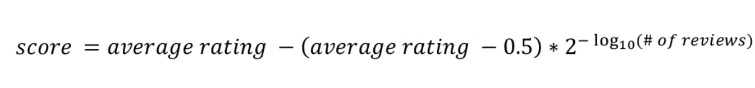

In [89]:
def get_score(x):
    #result = x[0] - (x[0] -0.5)*(2^(np.log(x[1])))
    result = x['mean'] - (x['mean'] -0.5)*(math.pow(2, -np.log(x['count'])))
    return result
pop_df['score'] = pop_df.apply(get_score, axis=1)

+ 평점 존재할 경우

In [99]:
import math
pop_df = interaction_df.groupby(item_id_var)[event].agg(['mean', 'count'])
pop_df = pd.DataFrame(pop_df.reset_index())
#item_average.columns = [item_id_var, 'average']
pop_df['score'] = pop_df.apply(get_score, axis=1)
pop_df = pop_df.sort_values('score', ascending=False)
pop_df['weight'] = pop_df['score'].apply(math.exp)

In [103]:
pop_list = pop_df.sample(n=10, weights='weight')[item_id_var].tolist()

+ 평점 없을 경우

In [104]:
pop_df = interaction_df.groupby(item_id_var)[event].agg(['count'])
pop_df = pd.DataFrame(pop_df.reset_index())
#pop_df['weight'] = pop_df['count'].apply(math.exp)

In [106]:
pop_list = pop_df.sample(n=10, weights='count')[item_id_var].tolist()

In [113]:
pop_df = item_df[item_df[item_id_var].isin(pop_list)]